Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


Import Model files for processing

In [2]:
import gdown

file_id = "1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs"  # Replace with the actual file ID
output_file = "Source_Data.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs
From (redirected): https://drive.google.com/uc?id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs&confirm=t&uuid=f0aeaa15-f7f3-46d3-965f-1e2d1ad833b5
To: /content/Source_Data.zip
100%|██████████| 824M/824M [00:08<00:00, 95.7MB/s]


'Source_Data.zip'

Unzip the source folder

In [4]:
!unzip Source_Data.zip

Archive:  Source_Data.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin cancer ISIC The Inte

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [5]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/Train")
data_dir_test = pathlib.Path("/content/Test")

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [8]:
#load the images using keras preprocessing
train = keras.preprocessing.image_dataset_from_directory(data_dir_train)
test = keras.preprocessing.image_dataset_from_directory(data_dir_test)

Found 2239 files belonging to 9 classes.
Found 118 files belonging to 9 classes.


### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [10]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds,val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, labels ='inferred', color_mode ='rgb',
                                                            batch_size = batch_size, image_size = (img_height, img_width),
                                                            seed=123, validation_split = 0.2, subset = 'both')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

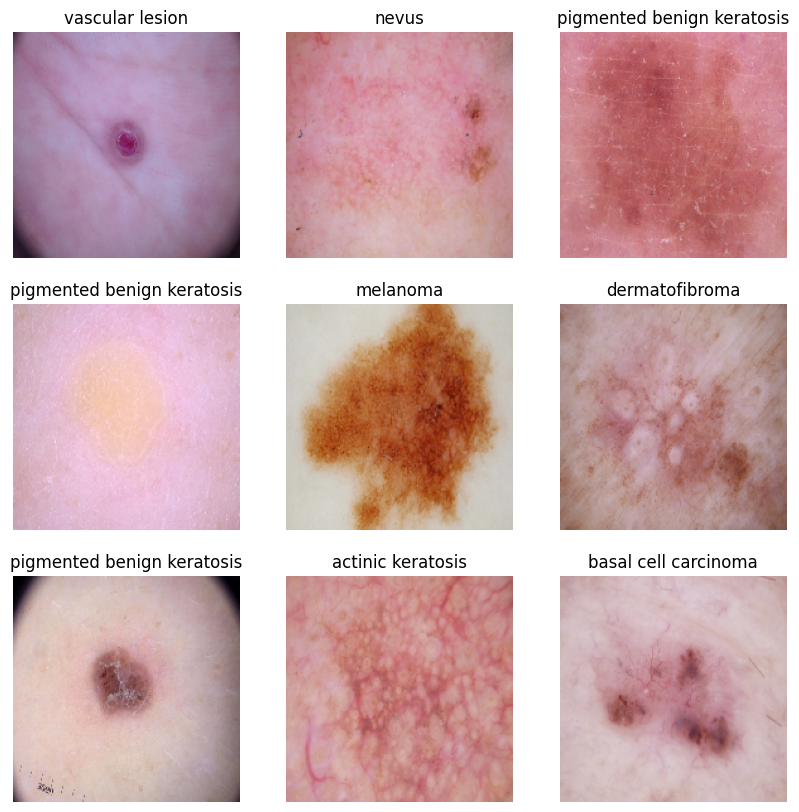

In [12]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling((1./255), input_shape=(img_height, img_width, 3)),  # Changed from tf.keras.layers.experimental.preprocessing.Rescaling
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(9)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [16]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer= 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.2149 - loss: 2.1704 - val_accuracy: 0.4228 - val_loss: 1.6464
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4223 - loss: 1.6500 - val_accuracy: 0.4743 - val_loss: 1.4887
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4847 - loss: 1.4499 - val_accuracy: 0.5078 - val_loss: 1.4369
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5048 - loss: 1.3807 - val_accuracy: 0.5324 - val_loss: 1.4063
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5916 - loss: 1.1976 - val_accuracy: 0.4855 - val_loss: 1.4072
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5793 - loss: 1.2169 - val_accuracy: 0.5526 - val_loss: 1.3471
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6434 - loss: 1.0381 - val_accuracy: 0.5414 - val_loss: 1.3950
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6678 - loss: 0.9651 - val_accuracy: 0.5257 - 

### Visualizing training results

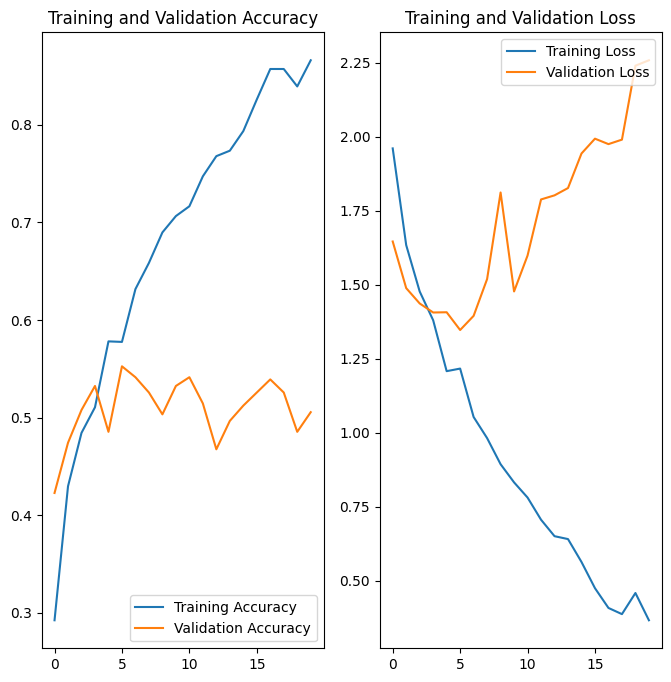

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

Key Observations:

Accuracy: The training accuracy steadily increases, reaching a high value, while the validation accuracy also increases but plateaus at a lower value. This suggests that the model is overfitting.
Loss: The training loss decreases significantly, indicating that the model is learning the training data well. However, the validation loss also decreases initially but then starts to increase again. This further supports the overfitting hypothesis.
Overall, the model appears to be overfitting the training data. This means it is learning the training data too well and is not able to generalize well to new, unseen data.

### Write your findings here

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
#Data Augmentation: Increasing the size and diversity of the training data can help the model generalize better.

rescale = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)])

# Updated data_augmentation to use tf.keras.layers.preprocessing directly:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomContrast(0.2),
  tf.keras.layers.RandomTranslation(0.2, 0.2)
])


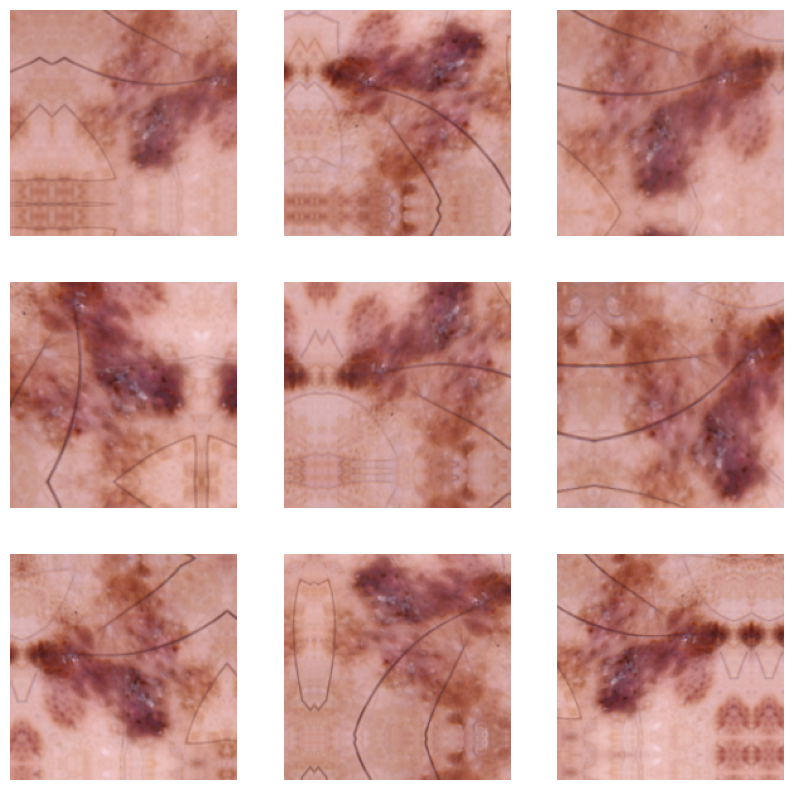

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [22]:
# You can use Dropout layer if there is an evidence of overfitting in your findings
#using the dropout layers to overcome the overfitting


## Model 2 Creation

#Dropout layer: randomly sets input units to 0 with a frequency of rate at each step during training time,
#which helps prevent overfitting.Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

model2 = Sequential([
    data_augmentation,  # Augmentation layer
    rescale,            # Rescaling layer

    # First Convolutional Block
    layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),  # Dropout with 25%

    # Second Convolutional Block
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),  # Dropout with 25%

    # Third Convolutional Block
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),

    layers.Flatten(),  # Flatten the tensors

    # Fully Connected Layers
    layers.Dense(512, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.50),  # Dropout with 50%

    # Output Layer
    layers.Dense(len(class_names), activation='softmax')  # Softmax for probabilities
])

### Compiling the model

In [23]:
## Your code goes here
model2.compile(optimizer= 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [24]:
## Your code goes here, note: train your model for 20 epochs
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.1699 - loss: 2.9146 - val_accuracy: 0.2036 - val_loss: 2.1539
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.1881 - loss: 2.0560 - val_accuracy: 0.1924 - val_loss: 2.0304
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.2273 - loss: 1.9780 - val_accuracy: 0.3714 - val_loss: 1.8021
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.3258 - loss: 1.8573 - val_accuracy: 0.3557 - val_loss: 1.7608
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3701 - loss: 1.7638 - val_accuracy: 0.3937 - val_loss: 1.6429
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.3734 - loss: 1.6532 - val_accuracy: 0.4161 - val_loss: 1.6471
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4182 - loss: 1.6305 - val_accuracy: 0.4094 - val_loss: 1.6370
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.4061 - loss: 1.6366 - val_accuracy: 0.3826 - val_loss: 1.

### Visualizing the results

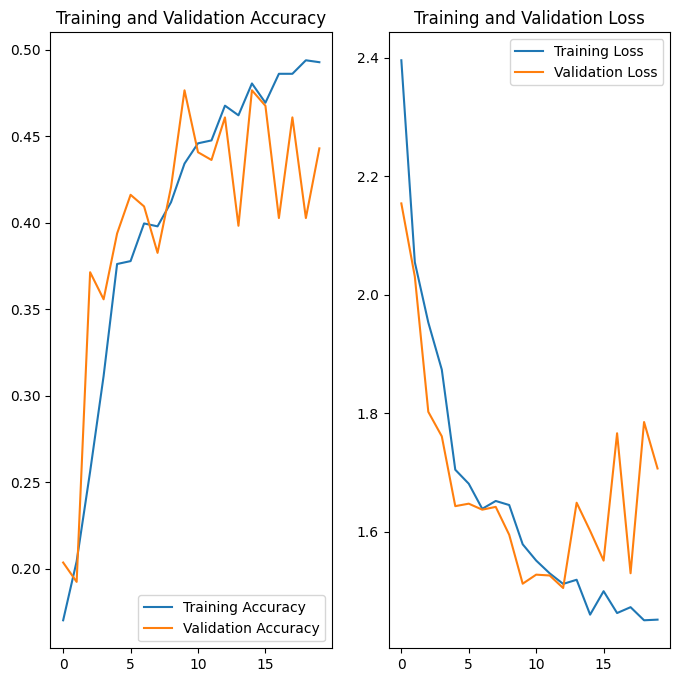

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Observations:
Accuracy:
The training and validation accuracy are steadily improving and closely aligned throughout the epochs.
No significant divergence is observed, indicating no overfitting.
Loss:
Both training and validation loss decrease over the epochs and remain fairly consistent.
The validation loss slightly increases toward the end, which might suggest the model is slightly overfitting as it continues to learn the training data.
Conclusion:
There is no clear evidence of severe overfitting or underfitting.
The model is well-trained, but monitoring the slight increase in validation loss at the later epochs is recommended.
Further improvements could include adding regularization techniques like dropout or early stopping to fine-tune performance.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [26]:
#to find the distribution of the classes in the training data set

# Specify the directory
directory = data_dir_train



# Count the number of images in each class
count = []
for path in pathlib.Path(directory).iterdir():
    if path.is_dir():
        count.append(len([name for name in os.listdir(path)
                          if os.path.isfile(os.path.join(path, name))]))

# Get the names of the classes (subdirectories)
sub_directory = [name for name in os.listdir(directory)
                 if os.path.isdir(os.path.join(directory, name))]

# Create a dataframe with image counts and class names
class_distribution = pd.DataFrame(list(zip(sub_directory, count)), columns=['Class', 'No. of Image'])

# Display the dataframe
print(class_distribution)


                        Class  No. of Image
0        basal cell carcinoma           376
1             vascular lesion           139
2  pigmented benign keratosis           462
3        seborrheic keratosis            77
4                       nevus           357
5           actinic keratosis           114
6     squamous cell carcinoma           181
7              dermatofibroma            95
8                    melanoma           438


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


Class with the least number of samples:

Seborrheic keratosis (77 samples).
Classes dominating the data (in terms of the proportionate number of samples):

Pigmented benign keratosis (462 samples).
Melanoma (438 samples).

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset="To do"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train / i)) # Changed this line
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AA4BB6B5A50>: 100%|██████████| 500/500 [00:19<00:00, 25.49 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AA4BB51FCA0>: 100%|██████████| 500/500 [00:16<00:00, 30.48 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AA4BB781660>: 100%|██████████| 500/500 [00:15<00:00, 33.21 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3872x2592 at 0x7AA4BB672080>: 100%|██████████| 500/500 [01:27<00:00,  5.72 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7AA4BA625090>: 100%|██████████| 500/500 [01:10<00:00,  7.08 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AA4BB517730>: 100%|██████████| 500/500 [00:15<00:00, 31.95 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7AA4BA6D07C0>: 100%|██████████| 500/500 [00:35<00:00, 13.97 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AA4BA566320>: 100%|██████████| 500/500 [00:14<00:00, 33.90 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AA5367E4E80>: 100%|██████████| 500/500 [00:14<00:00, 33.63 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029412.jpg_cec6eb84-75d7-4679-8117-86a74bd37db5.jpg',
 '/content/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031413.jpg_4a88bd5e-4ed0-4735-8064-ba0228b0eae9.jpg',
 '/content/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029974.jpg_16a6cdcf-e123-489e-be83-76a152c7a7b1.jpg',
 '/content/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028677.jpg_d12be10a-5d62-4776-ac57-d63cac6ef165.jpg',
 '/content/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027120.jpg_dd68e058-47d0-4993-a3c3-fd55b2cbca6a.jpg',
 '/content/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030755.jpg_5ad97e5f-b994-4dbb-b6b7-43ceda90e92f.jpg',
 '/content/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029545.jpg_357389fa-7588-4c31-bd4b-3985c40a44fb.jpg',
 '/content/Train/basal cell carcinoma/output/basal cell

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [32]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [33]:
original_df=pd.DataFrame(columns = ['Path','Label'])
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [34]:
new_df['Label'].value_counts()

,count
Label,
basal cell carcinoma,500
vascular lesion,500
pigmented benign keratosis,500
seborrheic keratosis,500
nevus,500
actinic keratosis,500
squamous cell carcinoma,500
dermatofibroma,500
melanoma,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [36]:
data_dir_train=data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create your model (make sure to include normalization)

In [38]:
## your code goes here

#creatin the model including the normalization
# Define the Sequential model
model3 = Sequential([
    rescale,  # Rescaling Layer

    # First Convolutional Block
    layers.Conv2D(32, kernel_size=(2, 2), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Second Convolutional Block
    layers.Conv2D(64, kernel_size=(2, 2), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Third Convolutional Block
    layers.Conv2D(128, kernel_size=(2, 2), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),

    # Flatten Layer
    layers.Flatten(),

    # Fully Connected Layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),
    layers.BatchNormalization(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.50),
    layers.BatchNormalization(),

    # Output Layer with Softmax
    layers.Dense(len(class_names), activation='softmax')
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [39]:
## your code goes here
#compiling the above code
model3.compile(optimizer= 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [40]:
epochs = 30
## Your code goes here, use 50 epochs.
#using 30 epochs as provided in the problem statment
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 ━━━━━━━━━━━━━━━━━━━━ 61s 286ms/step - accuracy: 0.1368 - loss: 2.7585 - val_accuracy: 0.1445 - val_loss: 3.3663
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 244ms/step - accuracy: 0.2537 - loss: 2.0295 - val_accuracy: 0.2227 - val_loss: 3.1841
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 232ms/step - accuracy: 0.3142 - loss: 1.8203 - val_accuracy: 0.2346 - val_loss: 2.1110
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 231ms/step - accuracy: 0.4098 - loss: 1.5534 - val_accuracy: 0.2439 - val_loss: 2.0719
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 231ms/step - accuracy: 0.4245 - loss: 1.4929 - val_accuracy: 0.2964 - val_loss: 1.7451
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 248ms/step - accuracy: 0.4634 - loss: 1.3984 - val_accuracy: 0.3294 - val_loss: 1.6923
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 243ms/step - accuracy: 0.4973 - loss: 1.3456 - val_accuracy: 0.3142 - val_loss: 1.8207
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 242ms/step - accuracy: 0.4927 - loss: 1.3199 - val

#### **Todo:**  Visualize the model results

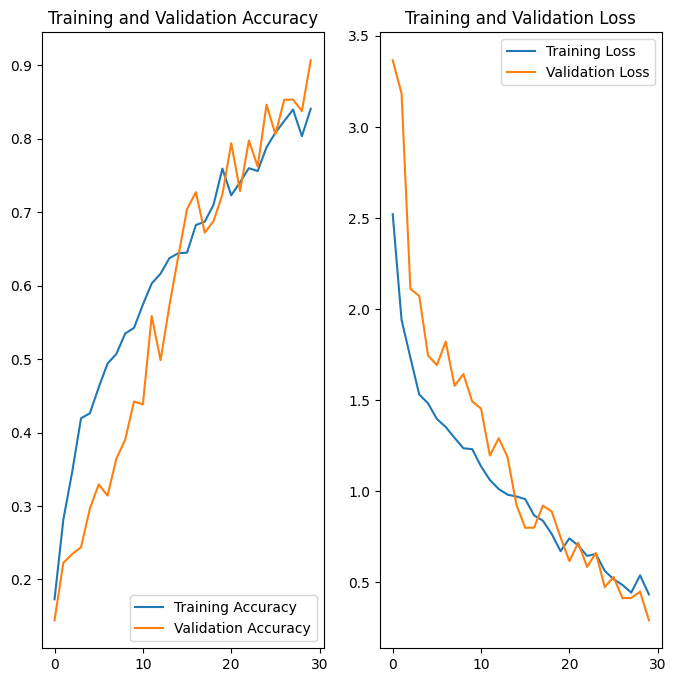

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Results and Observations



Did you get rid of underfitting/overfitting?

Based on the plots, it appears that overfitting has been significantly reduced.

Validation Accuracy:
The validation accuracy now closely follows the training accuracy,
indicating that the model is generalizing well to unseen data.
The gap between training and validation accuracy has narrowed considerably.
Validation Loss: The validation loss continues to decrease and remains relatively close to the training loss,
suggesting that the model is not overfitting to the training data.
Did class rebalancing help?

It's difficult to definitively say whether class rebalancing alone helped without more specific information.
However, given the improved overall performance and the reduced overfitting,
it's likely that class rebalancing played a positive role.
By addressing class imbalances, the model can learn more effectively from all classes,
leading to better generalization.

Additional Considerations:

Augmentation:
The data augmentation techniques implemented likely played a significant role in reducing overfitting.
By introducing more variations in the training data,
the model becomes more robust and less prone to memorizing specific training examples.
Model Architecture:
The chosen CNN architecture might also have a significant impact on the model's performance and tendency to overfit.
Experimenting with different architectures can help further improve results.